In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../../')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import Fixed_QSDE, QSDE
from sdebridge.utils import *

plt.style.use('ggplot')

In [3]:
d = 16
alpha = 1.0
sigma = 0.5

### Fixed Q

In [11]:
circle1 = sample_circle(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))
init_Q = eval_Q(jnp.tile(circle1, reps=(1, 1)), alpha, sigma)
init_Q = squeeze(init_Q, axis=0)
print(init_Q.shape)

sde_params = {
    "dimension": d,
    "num_steps": 100,
    "init_Q": init_Q
}
sde = Fixed_QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

(16, 16)


(5, 100, 16)


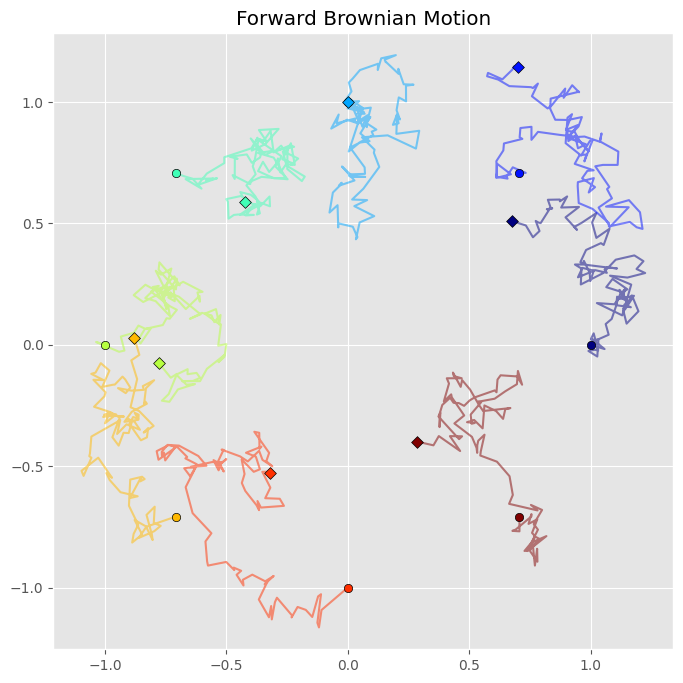

In [12]:
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=jnp.tile(circle1, reps=(5, 1)),
    rng=jax.random.PRNGKey(0)
)
print(forward_brownian_motion["trajectories"].shape)
plot_single_trajectory(forward_brownian_motion["trajectories"][0], title="Forward Brownian Motion")

In [13]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 256,
                "embedding_dim": 256,
                "act": 'gelu',
                "encoder_layer_dims": [256, 256, 256],
                "decoder_layer_dims": [256, 128, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 40,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = bridge.learn_p_score(initial_val=circle1, 
                                     setup_params=setup_params,
                                     rng=jax.random.PRNGKey(21),
                                     loss_calibration=False)

Training: 100%|██████████| 40/40 [01:15<00:00,  1.88s/epoch, Epoch=40, loss=7.6891]


In [14]:
circle2 = sample_circle(num_points=d//2, scale=1.1, shifts=jnp.array([0.0, 0.0]))

In [15]:
score_p = jax.tree_util.Partial(lambda val, time, score_p_state: eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state)
backward_brownian_bridge = bridge.simulate_backward_bridge(initial_val=jnp.tile(circle1, reps=(10, 1)), 
                                                           terminal_val=jnp.tile(circle2, reps=(10, 1)),
                                                           score_p=score_p,
                                                           rng=jax.random.PRNGKey(13))

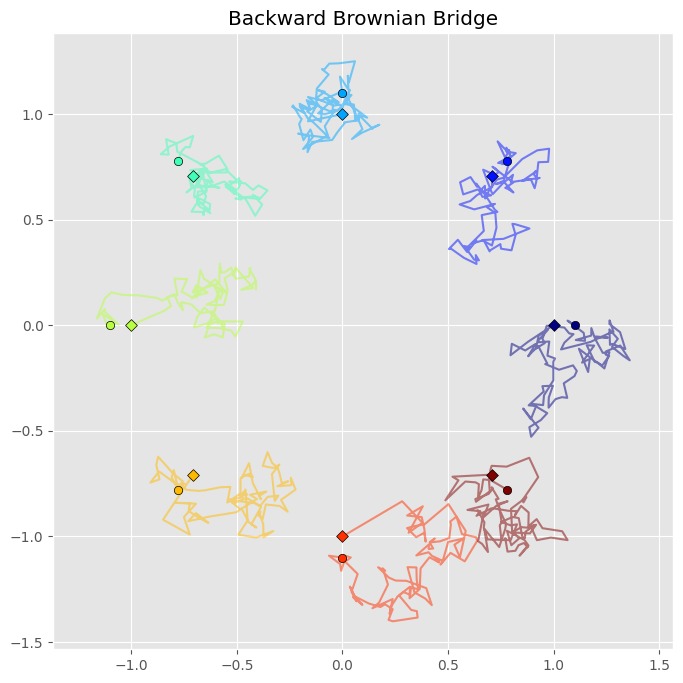

In [16]:
plot_single_trajectory(backward_brownian_bridge["trajectories"][6], title="Backward Brownian Bridge")

In [17]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 256,
                "embedding_dim": 256,
                "act": 'gelu',
                "encoder_layer_dims": [256, 256, 256],
                "decoder_layer_dims": [256, 128, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 40,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_star_state = bridge.learn_p_star_score(initial_val=circle1,
                                               terminal_val=circle2,
                                               score_p=score_p,
                                               setup_params=setup_params,
                                               rng=jax.random.PRNGKey(141),
                                               loss_calibration=False)

Training: 100%|██████████| 40/40 [03:31<00:00,  5.30s/epoch, Epoch=40, loss=7.4664]


In [18]:
score_h = jax.tree_util.Partial(lambda val, time, score_p_state, score_p_star_state: eval_score(state=score_p_star_state, val=val, time=time) - eval_score(state=score_p_state, val=val, time=time), score_p_state=score_p_state, score_p_star_state=score_p_star_state)
forward_brownian_bridge = bridge.simulate_forward_bridge(initial_val=jnp.tile(circle1, reps=(5, 1)), 
                                                         terminal_val=jnp.tile(circle2, reps=(5, 1)),
                                                         score_h=score_h,
                                                         rng=jax.random.PRNGKey(11))

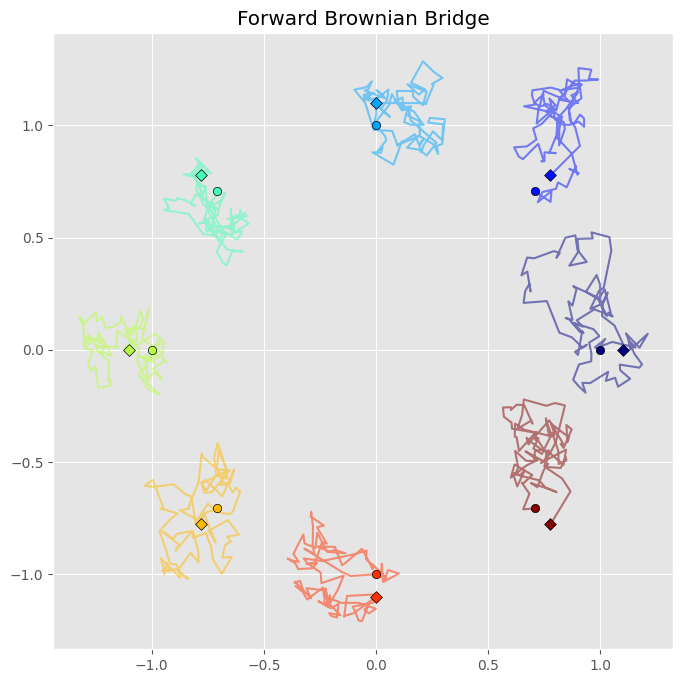

In [19]:
plot_single_trajectory(forward_brownian_bridge["trajectories"][4], title="Forward Brownian Bridge")

### Variable Q

In [4]:
sde_params = {
    "dimension": d,
    "num_steps": 100,
    "alpha": alpha,
    "sigma": sigma,
}
sde = QSDE(sde_params=sde_params)
bridge=DiffusionBridge(sde)

In [5]:
circle1 = sample_circle(num_points=d//2, scale=1.0, shifts=jnp.array([0.0, 0.0]))
circle2 = sample_circle(num_points=d//2, scale=1.1, shifts=jnp.array([0.0, 0.0]))

In [9]:
forward_brownian_motion = bridge.simulate_forward_process(
    initial_val=circle1,
    rng=jax.random.PRNGKey(0),
    num_batches=4
)

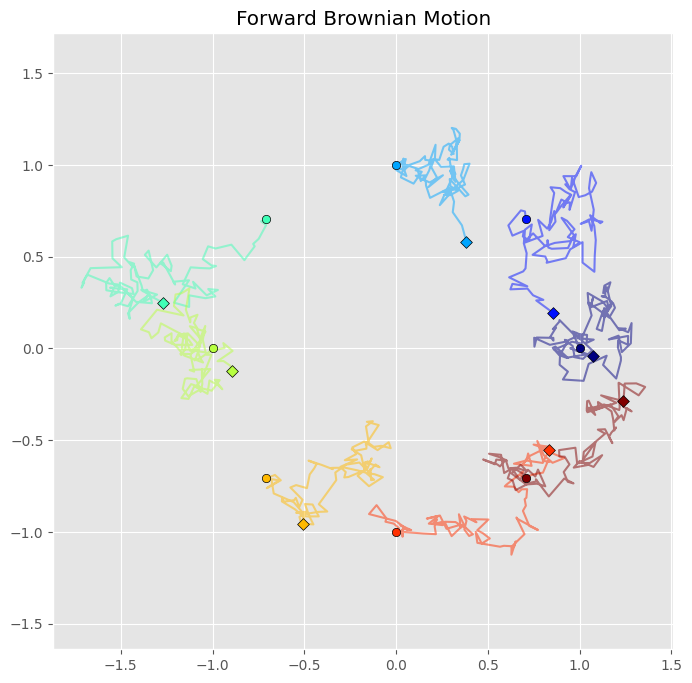

In [12]:
plot_single_trajectory(forward_brownian_motion["trajectories"][3], title="Forward Brownian Motion")

In [8]:
setup_params = {
    "network": {"out_dim": sde.dim,
                "time_embedding_dim": 256,
                "embedding_dim": 256,
                "act": 'gelu',
                "encoder_layer_dims": [256, 256, 256],
                "decoder_layer_dims": [256, 128, 64],
                "using_batchnorm": False},
    "training": {"batch_size": 32,
                 "num_epochs": 40,
                 "num_batches_per_epoch": 50,
                 "learning_rate": 5e-3}
}
score_p_state = bridge.learn_p_score(initial_val=circle1, 
                                     setup_params=setup_params,
                                     rng=jax.random.PRNGKey(21),
                                     loss_calibration=False)

Training:   0%|          | 0/40 [00:00<?, ?epoch/s]


InconclusiveDimensionOperation: Cannot divide evenly the sizes of shapes () and (-1, 2)